In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [3]:
X

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [4]:
import numpy as np
import pandas as pd

data = X.copy()

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove missing customer IDs
data = data[~data['CustomerID'].isna()]

# Remove negative quantity (returns/cancellations)
data = data[data['Quantity'] > 0]

# Remove negative or zero prices
data = data[data['UnitPrice'] > 0]

# Create Revenue column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
# Convert to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Today's reference date = max date in dataset
ref_date = data['InvoiceDate'].max()

# Group by CustomerID
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'Quantity': 'count',                                  # Frequency (proxy)
    'TotalPrice': 'sum'                                   # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [5]:
import numpy as np
import pandas as pd

# Start from your dataframe X
data = X.copy()

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove missing CustomerID
data = data[~data['CustomerID'].isna()]

# Remove negative or zero quantity
data = data[data['Quantity'] > 0]

# Remove negative or zero prices
data = data[data['UnitPrice'] > 0]

# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Reference date = max invoice date
ref_date = data['InvoiceDate'].max()

# Build RFM table (correct for your dataset)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'Quantity': 'count',                                  # Frequency
    'TotalPrice': 'sum'                                   # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [6]:
import numpy as np

rfm_log = rfm.copy()

# Add +1 to avoid log(0)
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.786897,0.693147,11.253955
12347.0,0.693147,5.209486,8.368925
12348.0,4.317488,3.465736,7.494564
12349.0,2.944439,4.304065,7.472245
12350.0,5.736572,2.890372,5.815324


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled[:5]

array([[ 1.40989446, -2.4343873 ,  3.70622476],
       [-2.14649825,  1.17748295,  1.41184341],
       [ 0.38397128, -0.21705358,  0.7164889 ],
       [-0.57467446,  0.45338686,  0.6987394 ],
       [ 1.37475812, -0.6771919 , -0.6189622 ]])

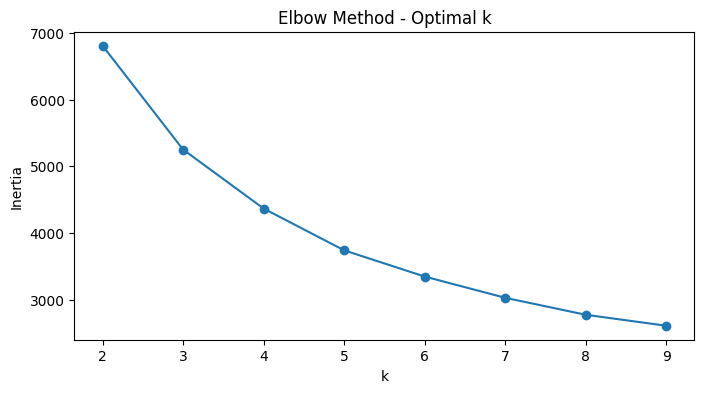

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [9]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"k={k} → silhouette={score:.4f}")

k=2 → silhouette=0.3998
k=3 → silhouette=0.3056
k=4 → silhouette=0.3071
k=5 → silhouette=0.2763
k=6 → silhouette=0.2716
k=7 → silhouette=0.2634
k=8 → silhouette=0.2624
k=9 → silhouette=0.2540


In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,2
12348.0,74,31,1797.24,1
12349.0,18,73,1757.55,1
12350.0,309,17,334.40,3


In [11]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster':'NumCustomers'})

cluster_profile

,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,18.436740,37.817518,597.565085,822
1,90.346481,82.204176,1537.402678,1293
2,11.084746,289.792978,7279.545109,826
3,183.218325,15.131711,300.245870,1397


In [12]:
segment_map = {
    2: 'VIP / High-Value Customers',
    1: 'Loyal High-Spending Customers',
    0: 'Regular Active Customers',
    3: 'At-Risk / Dormant Customers'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,325,1,77183.60,1,Loyal High-Spending Customers
12347.0,1,182,4310.00,2,VIP / High-Value Customers
12348.0,74,31,1797.24,1,Loyal High-Spending Customers
12349.0,18,73,1757.55,1,Loyal High-Spending Customers
12350.0,309,17,334.40,3,At-Risk / Dormant Customers


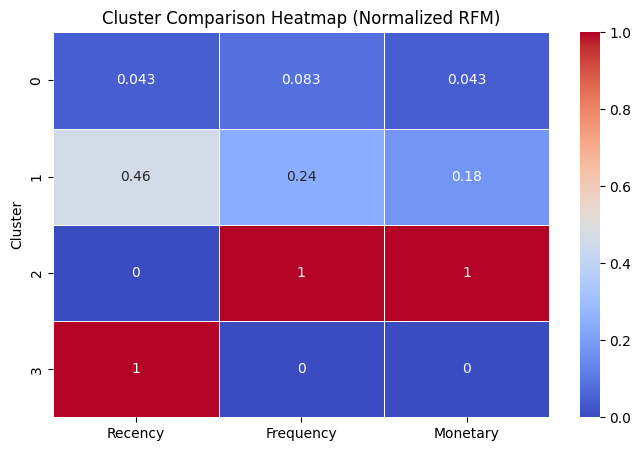

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute cluster averages
cluster_avg = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

# Normalize for visualization
cluster_norm = cluster_avg.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(8, 5))
sns.heatmap(cluster_norm, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Cluster Comparison Heatmap (Normalized RFM)")
plt.show()

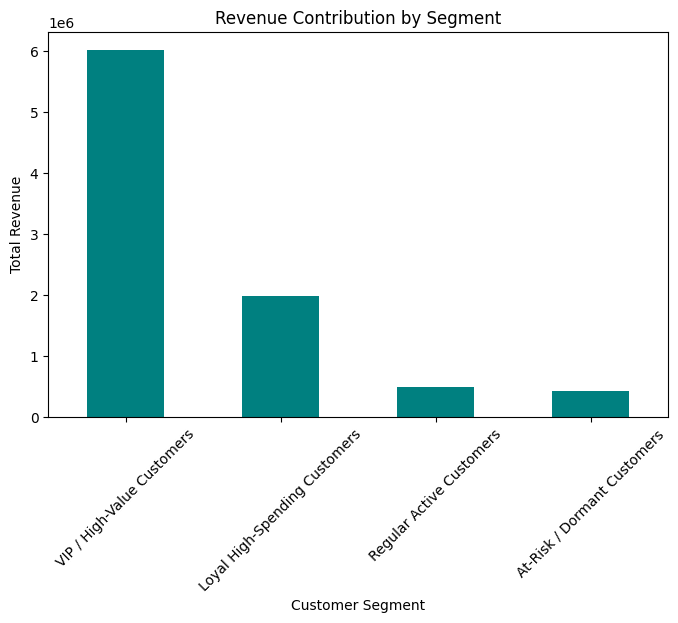

,Monetary
Segment,
VIP / High-Value Customers,6012904.260
Loyal High-Spending Customers,1987861.663
Regular Active Customers,491198.500
At-Risk / Dormant Customers,419443.481


In [14]:
# Add revenue per customer (Monetary is already total spent)
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
segment_revenue.plot(kind='bar', color='teal')
plt.title("Revenue Contribution by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

segment_revenue

In [19]:
business_strategy = pd.DataFrame({
    'Segment': [
        'VIP / High-Value Customers',
        'Loyal High-Spending Customers',
        'Regular Active Customers',
        'At-Risk / Dormant Customers'
    ],
    'Behavior Summary': [
        'Very recent, extremely frequent buyers with the highest spending',
        'High spenders with good purchase frequency but less recent activity',
        'Recently active customers with moderate purchase frequency and spend',
        'Long inactive customers with low purchase frequency and low spend'
    ],
    'Recommended Actions': [
        'Exclusive rewards, premium loyalty programs, early access to products',
        'Personalized offers, loyalty incentives, reminders to increase recency',
        'Upsell and cross-sell campaigns, personalized recommendations',
        'Win-back campaigns, time-limited discounts, reactivation emails'
    ],
    'Goal': [
        'Maximize lifetime value and retention',
        'Increase recency and transition to VIP segment',
        'Increase frequency and average order value',
        'Reduce churn and recover lost revenue'
    ]
})

business_strategy

,Segment,Behavior Summary,Recommended Actions,Goal
0,VIP / High-Value Customers,"Very recent, extremely frequent buyers with th...","Exclusive rewards, premium loyalty programs, e...",Maximize lifetime value and retention
1,Loyal High-Spending Customers,High spenders with good purchase frequency but...,"Personalized offers, loyalty incentives, remin...",Increase recency and transition to VIP segment
2,Regular Active Customers,Recently active customers with moderate purcha...,"Upsell and cross-sell campaigns, personalized ...",Increase frequency and average order value
3,At-Risk / Dormant Customers,Long inactive customers with low purchase freq...,"Win-back campaigns, time-limited discounts, re...",Reduce churn and recover lost revenue


In [21]:
rfm_strategy = rfm.merge(business_strategy, on='Segment', how='left')
rfm_strategy.head()

,Recency,Frequency,Monetary,Cluster,Segment,Behavior Summary,Recommended Actions,Goal
0,325,1,77183.60,1,Loyal High-Spending Customers,High spenders with good purchase frequency but...,"Personalized offers, loyalty incentives, remin...",Increase recency and transition to VIP segment
1,1,182,4310.00,2,VIP / High-Value Customers,"Very recent, extremely frequent buyers with th...","Exclusive rewards, premium loyalty programs, e...",Maximize lifetime value and retention
2,74,31,1797.24,1,Loyal High-Spending Customers,High spenders with good purchase frequency but...,"Personalized offers, loyalty incentives, remin...",Increase recency and transition to VIP segment
3,18,73,1757.55,1,Loyal High-Spending Customers,High spenders with good purchase frequency but...,"Personalized offers, loyalty incentives, remin...",Increase recency and transition to VIP segment
4,309,17,334.40,3,At-Risk / Dormant Customers,Long inactive customers with low purchase freq...,"Win-back campaigns, time-limited discounts, re...",Reduce churn and recover lost revenue


In [22]:
rfm_strategy.to_csv("customer_segments_with_strategy.csv")

In [24]:
rfm.to_csv("rfm_final.csv")